# Exercise 10.1: Maximum Radius Orbit Transfer (Indirect Method)

This notebook solves Exercise 10.1 using the indirect method. The problem is to maximize the final radius of a spacecraft in a fixed time, subject to thrust constraints and a final circular orbit condition. 

The indirect method requires deriving the Hamiltonian, the costate (adjoint) equations, and the transversality conditions, which results in a two-point boundary value problem (BVP). We solve this BVP using a shooting method.

All calculations are performed in a normalised, canonical unit system as advised in the exercise, which is critical for numerical stability.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from orbit_raiser import OrbitParams, OrbitIC, IndirectShootingSolver, UnitConverter

MU_SUN = 1.327E11       # km^3/s^2
THRUST = 1.0             # N = kg*m/s^2
THRUST_KM = THRUST * 1e-3  # kg*km/s^2
BETA_DAY = 2.0           # kg/day
BETA_SEC = BETA_DAY / (24.0 * 3600.0) # kg/s

R0_PHYS = 1.495978E8     # km (1 AU)
M0_PHYS = 1000.0         # kg
TF_DAYS = 180.0          # days
TF_SEC = TF_DAYS * 24.0 * 3600.0

In [2]:
uc = UnitConverter(du=R0_PHYS, mu=MU_SUN, mu_val=1.0, m0=M0_PHYS)
print(uc)

p = OrbitParams(
    mu=uc.mu_norm,
    T_norm=uc.normalize_thrust(THRUST_KM),
    beta_norm=uc.normalize_mdot(BETA_SEC)
)

ic = OrbitIC(
    r0=uc.normalize_dist(R0_PHYS),
    u0=uc.normalize_vel(0.0),
    v0=uc.normalize_vel(np.sqrt(MU_SUN / R0_PHYS)),
    m0=uc.normalize_mass(M0_PHYS)
)

tf_norm = uc.normalize_time(TF_SEC)
print(f"Normalised Params: {p}")
print(f"Normalised ICs: {ic}")
print(f"Normalised Time: tf = {tf_norm:.4f}")

--- Unit Converter ---
DU = 1.496e+08 km
TU = 5.023e+06 s  (58.14 days)
MU = 1.000e+03 kg
VU = 2.978e+01 km/s
------------------------
Normalised Params: OrbitParams(mu=1.0, T_norm=np.float64(0.1686473380922381), beta_norm=np.float64(0.11627024884320887))
Normalised ICs: OrbitIC(r0=1.0, u0=np.float64(0.0), v0=np.float64(0.9999999999999999), m0=1.0)
Normalised Time: tf = 3.0962


In [3]:
solver = IndirectShootingSolver(p, ic, tf_norm)

initial_guesses = [
    np.array([-0.5, -0.1, -0.1, -0.01]),
    np.array([-1.0, -0.2, -0.2, -0.05]),
    np.array([-2.0, -0.5, -0.5, -0.1]),
    np.array([-0.8, -0.15, -0.15, -0.03]),
    np.array([-1.5, -0.3, -0.3, -0.08]),
    np.array([-3.0, -0.8, -0.8, -0.15]),
    np.array([-0.3, -0.05, -0.05, -0.01]),
    np.array([-2.5, -0.6, -0.6, -0.12]),
]

sol = None
p0_final = None
for i, p0_guess in enumerate(initial_guesses):
    try:
        print(f"Trying initial guess {i+1}: {p0_guess}")
        sol = solver.solve(
            p0_guess, 
            tol=1e-11,
            ftol=1e-9,
            verbose=False,
            maxfev=5000
        )
        if sol.success:
            print(f"Success! Found solution with p0 = {sol.p0}")
            p0_final = sol.p0
            break
        else:
            print(f"Failed: {sol.message}\n")
    except Exception as e:
        print(f"Failed with exception: {e}\n")
        continue

if sol is None or not sol.success:
    print("All initial guesses failed. Exiting.")
else:
    print("\n--- Solution --- ")
    print(f"Success: {sol.success}")
    print(f"Message: {sol.message}")
    
    sol = solver.post_process(sol)
    
    rf_norm = sol.r[-1]
    rf_phys = uc.denormalize_dist(rf_norm)
    print(f"\nNormalised Final Radius: {rf_norm:.6f} DU")
    print(f"Physical Final Radius:   {rf_phys/R0_PHYS:.6f} AU")
    print(f"Physical Final Radius:   {rf_phys:.3e} km")
    print(f"Final Mass:              {uc.denormalize_mass(sol.m[-1]):.2f} kg")

Trying initial guess 1: [-0.5  -0.1  -0.1  -0.01]


c:\Users\cvest\Claudio\Princeton\4th Year\MAE 546\PSet2\orbit_raiser.py:184: OptimizeWarning: Unknown solver options: maxfev
  res = root(


Success! Found solution with p0 = [ 1.61271252  0.83681312  1.79809727 -0.67515918]

--- Solution --- 
Success: True
Message: The relative error between two consecutive iterates is at most 0.000000

Normalised Final Radius: 1.579543 DU
Physical Final Radius:   1.579543 AU
Physical Final Radius:   2.363e+08 km
Final Mass:              640.00 kg


### Plots of Optimal Solution

The plots show the normalised state, costate, and control trajectories over the fixed time interval [0, $t_f$].

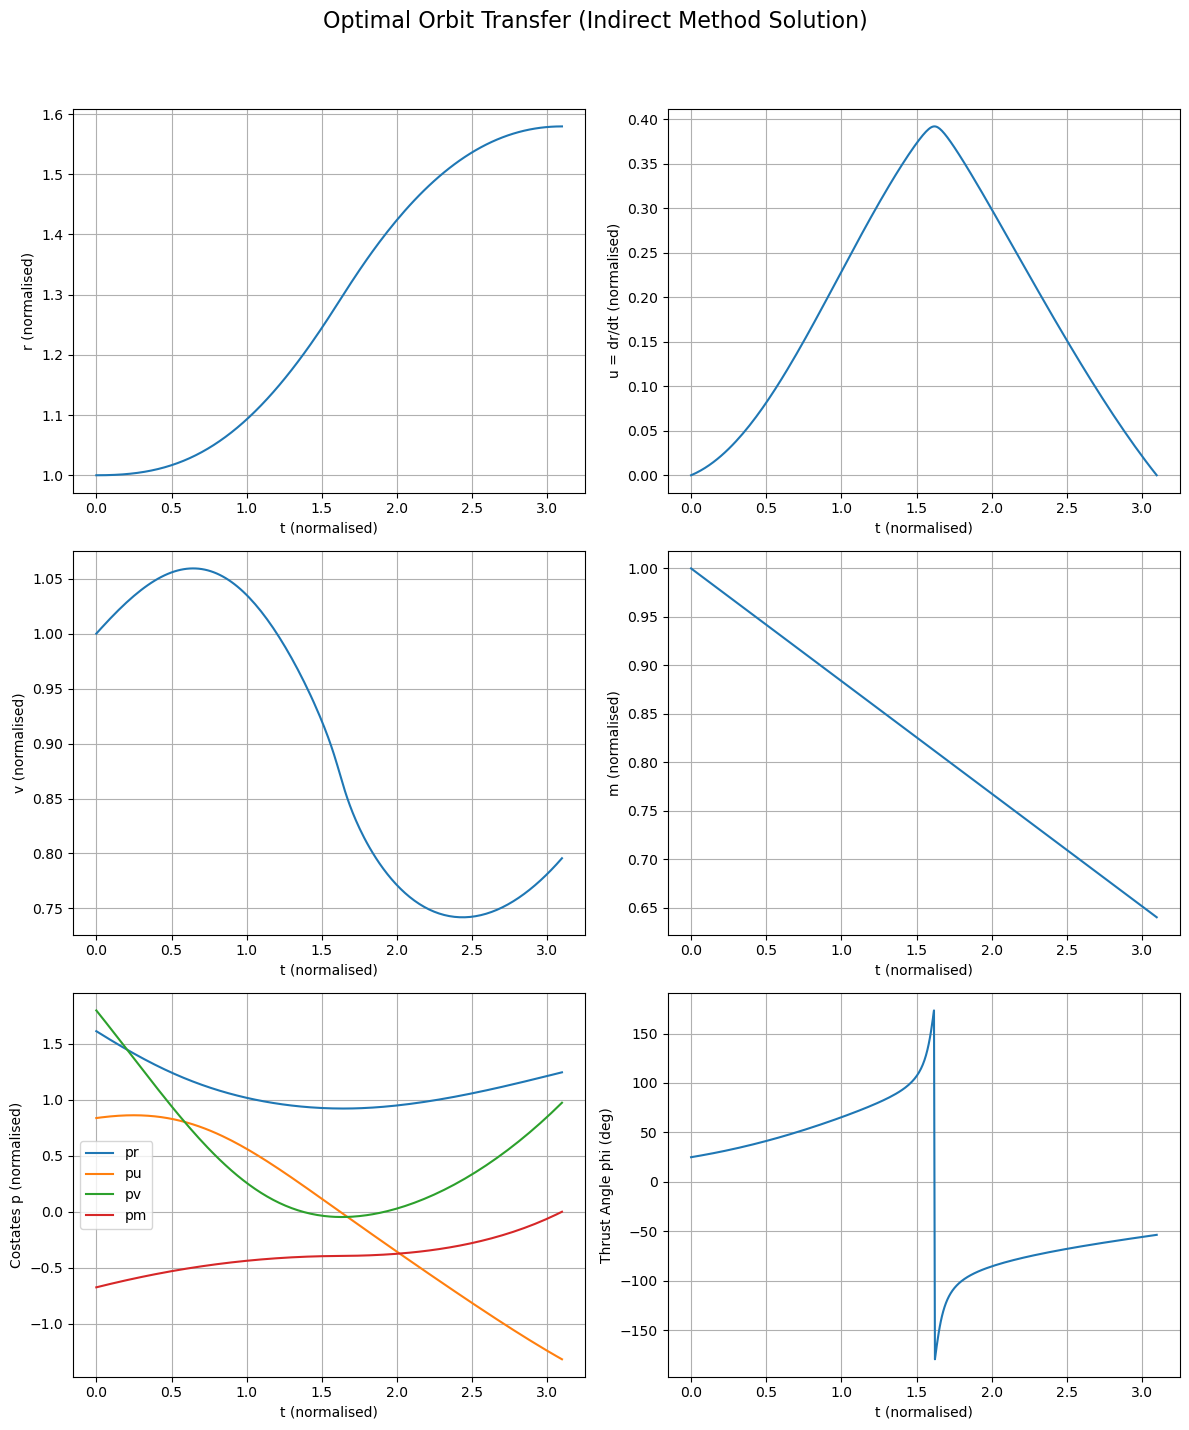

In [4]:
if sol.success:
    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    fig.suptitle('Optimal Orbit Transfer (Indirect Method Solution)', fontsize=16)
    
    # States
    axs[0, 0].plot(sol.t, sol.r)
    axs[0, 0].set_ylabel('r (normalised)')
    axs[0, 1].plot(sol.t, sol.u)
    axs[0, 1].set_ylabel('u = dr/dt (normalised)')
    axs[1, 0].plot(sol.t, sol.v)
    axs[1, 0].set_ylabel('v (normalised)')
    axs[1, 1].plot(sol.t, sol.m)
    axs[1, 1].set_ylabel('m (normalised)')

    # Costates
    axs[2, 0].plot(sol.t, sol.pr, label='pr')
    axs[2, 0].plot(sol.t, sol.pu, label='pu')
    axs[2, 0].plot(sol.t, sol.pv, label='pv')
    axs[2, 0].plot(sol.t, sol.pm, label='pm')
    axs[2, 0].set_ylabel('Costates p (normalised)')
    axs[2, 0].legend()

    # Control
    axs[2, 1].plot(sol.t, sol.phi * 180.0 / np.pi)
    axs[2, 1].set_ylabel('Thrust Angle phi (deg)')

    for ax in axs.flat:
        ax.set_xlabel('t (normalised)')
        ax.grid(True)

    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    plt.show()
else:
    print("\nBVP solver did not converge. Cannot plot results.")
    print("This is common with the indirect method. Try a different p0_guess.")

### Optimality of the Solution

#### Comment on optimality:
If the solver converges (i.e., `sol.success == True`), the numerical solution is one that satisfies the first-order necessary conditions of optimal control. These are the Hamilton's canonical equations (state and costate ODEs), the optimality condition ($\phi^*$ maximises H), and the transversality conditions.

The BVP solver `scipy.optimize.root` finds a solution $P_0$ such that the 4 terminal residuals are driven to zero within the specified tolerance (`ftol=1e-10`). This high precision gives strong confidence that we have found a true extremal trajectory.

#### Additional steps to improve/verify:
1.  Second-Order Conditions: To *guarantee* this is a local minimum (maximum radius), one would need to check the second-order necessary conditions (e.g., Legendre-Clebsch and the Jacobi condition). The Legendre-Clebsch condition, $\nabla_{\phi \phi} H \le 0$, is satisfied since $\frac{\partial^2 H}{\partial \phi^2} = -\frac{T\lambda}{m}$, which is negative (for a maximisation problem, this is correct).
2.  Robustness: One could re-solve the BVP with a tighter tolerance (e.g., `tol=1e-13`) to ensure the solution doesn't change significantly.
3.  Compare to Direct Method: As suggested in Exercise 10.2, solving this with a direct method (like collocation) and comparing the final objective $r(t_f)$ would provide a suitable validation. If both methods converge to the same solution, it is almost certainly the globally optimal one.